In [1]:
import pandas as pd
from six.moves import urllib
import time
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 20)
pd.set_option('display.float_format', lambda x: "{0:,.3f}".format(x))

In [2]:
from yqd import *

# 'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=-630950400&period2=1551686400&interval=1d&events=history&crumb=7yeobYpz5RM'
quote = load_yahoo_quote('^GSPC', '19500103', 'today', 'quote', 'dataframe')
quote

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.660,16.660,16.660,16.660,16.660,1260000
1,1950-01-04,16.850,16.850,16.850,16.850,16.850,1890000
2,1950-01-05,16.930,16.930,16.930,16.930,16.930,2550000
3,1950-01-06,16.980,16.980,16.980,16.980,16.980,2010000
4,1950-01-09,17.080,17.080,17.080,17.080,17.080,2520000
5,1950-01-10,17.030,17.030,17.030,17.030,17.030,2160000
6,1950-01-11,17.090,17.090,17.090,17.090,17.090,2630000
7,1950-01-12,16.760,16.760,16.760,16.760,16.760,2970000
8,1950-01-13,16.670,16.670,16.670,16.670,16.670,3330000
9,1950-01-16,16.720,16.720,16.720,16.720,16.720,1460000


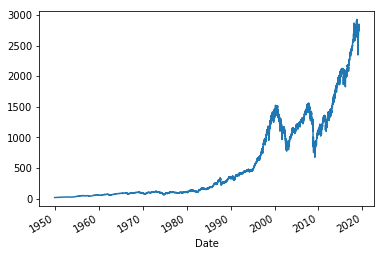

In [3]:
quote.set_index('Date')['Adj Close'].plot()

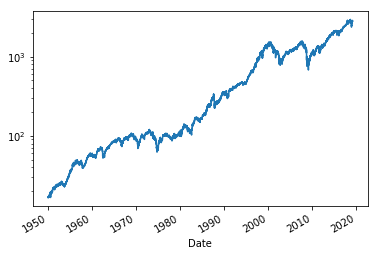

In [4]:
quote.set_index('Date')['Adj Close'].plot().set_yscale('log')

In [5]:
quote['Year'] = quote['Date'].map(lambda x:x.year)
quote

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1950-01-03,16.660,16.660,16.660,16.660,16.660,1260000,1950
1,1950-01-04,16.850,16.850,16.850,16.850,16.850,1890000,1950
2,1950-01-05,16.930,16.930,16.930,16.930,16.930,2550000,1950
3,1950-01-06,16.980,16.980,16.980,16.980,16.980,2010000,1950
4,1950-01-09,17.080,17.080,17.080,17.080,17.080,2520000,1950
5,1950-01-10,17.030,17.030,17.030,17.030,17.030,2160000,1950
6,1950-01-11,17.090,17.090,17.090,17.090,17.090,2630000,1950
7,1950-01-12,16.760,16.760,16.760,16.760,16.760,2970000,1950
8,1950-01-13,16.670,16.670,16.670,16.670,16.670,3330000,1950
9,1950-01-16,16.720,16.720,16.720,16.720,16.720,1460000,1950


In [6]:
last_close = float(quote.tail(1)['Adj Close'])
last_close

2800.709961

# We are trying to simulate the following scenario:
1. Someone want to invest 10000 each year<br>
1. He is trying to find which day to invest that 10000<br>
1. We'll see that the whether the timing plays a big role
***


In [7]:
def find_purchase_price(quote):
   
    aggregation =  {
        'Adj Close':  [
                       'max',  # Worst case, always to purchase at that year's highest point
                       'min',  # Best case, always to purchase at that year's lowest point
                       'mean', # Purchase at average point
                       np.random.choice # Doesn't care, random pick a day to invest
                      ]
        }
    
    
    every_year = quote.groupby('Year').agg(aggregation)
    every_year.columns = every_year.columns.get_level_values(1)
    every_year.reset_index()
    # the renaming in aggregation dict is deprecated, explicitly rename here:
    every_year.columns = ['Max', 'Min', 'Avg', 'Rand']
    return every_year

every_year = find_purchase_price(quote)
every_year

,Max,Min,Avg,Rand
Year,,,,
1950,20.430,16.660,18.397,17.280
1951,23.850,20.690,22.322,22.830
1952,26.590,23.090,24.496,23.950
1953,26.660,22.710,24.723,24.400
1954,35.980,24.800,29.724,32.630
1955,46.410,34.580,40.499,42.100
1956,49.640,43.110,46.640,46.970
1957,49.130,38.980,44.423,43.140
1958,55.210,40.330,46.203,41.360


In [8]:
def invest(amount, purchase_pricing):
    purchase_pricing["MaxShare"] = amount/purchase_pricing['Max']
    purchase_pricing['MinShare'] = amount/purchase_pricing['Min']
    purchase_pricing['AvgShare'] = amount/purchase_pricing['Avg']
    purchase_pricing['RandShare'] = amount/purchase_pricing['Rand']
    return purchase_pricing

every_year_investment = 12000.0
every_year = invest(every_year_investment, every_year)
every_year

,Max,Min,Avg,Rand,MaxShare,MinShare,AvgShare,RandShare
Year,,,,,,,,
1950,20.430,16.660,18.397,17.280,587.372,720.288,652.271,694.444
1951,23.850,20.690,22.322,22.830,503.145,579.990,537.589,525.624
1952,26.590,23.090,24.496,23.950,451.297,519.706,489.873,501.044
1953,26.660,22.710,24.723,24.400,450.113,528.402,485.386,491.803
1954,35.980,24.800,29.724,32.630,333.519,483.871,403.713,367.760
1955,46.410,34.580,40.499,42.100,258.565,347.021,296.305,285.036
1956,49.640,43.110,46.640,46.970,241.741,278.358,257.293,255.482
1957,49.130,38.980,44.423,43.140,244.250,307.850,270.128,278.164
1958,55.210,40.330,46.203,41.360,217.352,297.545,259.721,290.135


In [9]:
def get_irr(final_value):
    return np.irr(np.append(np.full(len(every_year), -every_year_investment),final_value))*100

def get_result(every_year):
    today = every_year.sum()

    max_value = today['MaxShare']*last_close
    min_value = today['MinShare']*last_close
    avg_value = today['AvgShare']*last_close
    rand_value = today['RandShare']*last_close

    print ("Buy On Highest Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(max_value, get_irr(max_value)))
    print ("Buy On Lowest Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(min_value, get_irr(min_value)))
    print ("Buy On Average Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(avg_value, get_irr(avg_value)))
    print ("Buy On Random Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(rand_value, get_irr(rand_value)))

get_result(every_year)

Buy On Highest Day: $19,668,918.07, Interal Return Rate:6.90%
Buy On Lowest Day: $24,442,365.06, Interal Return Rate:7.31%
Buy On Average Day: $21,711,728.82, Interal Return Rate:7.09%
Buy On Random Day: $21,905,575.04, Interal Return Rate:7.11%


In [10]:
print ("No investment:  ${0:12,.2f}".format(len(every_year)*every_year_investment))
print ("3% interest CD: ${0:12,.2f}".format(np.fv(0.03, 70, -every_year_investment, 0)))


No investment:  $  840,000.00
3% interest CD: $2,767,128.76


In [11]:
try_again = find_purchase_price(quote)
invest(every_year_investment, try_again)
get_result(try_again)

Buy On Highest Day: $19,668,918.07, Interal Return Rate:6.90%
Buy On Lowest Day: $24,442,365.06, Interal Return Rate:7.31%
Buy On Average Day: $21,711,728.82, Interal Return Rate:7.09%
Buy On Random Day: $21,892,943.86, Interal Return Rate:7.10%


In [12]:
# https://www.dividend.com/dividend-stocks/uncategorized/other/spy-spdr-sandp-500/
# median dividen is 1.75%, we use 1% to simulate the tax burdens
def calc_dividend(row):
    return row["RandShare"]*1.01**(2019-int(row.name))

def add_dividend(every_year):
    every_year["RandShareWithDividend"] = every_year.apply(calc_dividend, axis=1)
    
add_dividend(try_again)

In [13]:
try_again

,Max,Min,Avg,Rand,MaxShare,MinShare,AvgShare,RandShare,RandShareWithDividend
Year,,,,,,,,,
1950,20.430,16.660,18.397,17.440,587.372,720.288,652.271,688.073,"1,367.129"
1951,23.850,20.690,22.322,21.960,503.145,579.990,537.589,546.448,"1,074.985"
1952,26.590,23.090,24.496,23.680,451.297,519.706,489.873,506.757,987.033
1953,26.660,22.710,24.723,24.660,450.113,528.402,485.386,486.618,938.423
1954,35.980,24.800,29.724,28.290,333.519,483.871,403.713,424.178,809.912
1955,46.410,34.580,40.499,42.750,258.565,347.021,296.305,280.702,530.656
1956,49.640,43.110,46.640,46.050,241.741,278.358,257.293,260.586,487.751
1957,49.130,38.980,44.423,44.260,244.250,307.850,270.128,271.125,502.453
1958,55.210,40.330,46.203,41.630,217.352,297.545,259.721,288.254,528.906


In [14]:
def get_value_with_dividend(every_year):
    today_with_dividend = every_year.sum()
    rand_value_with_dividen = today_with_dividend['RandShareWithDividend']*last_close*0.85
    print ("Buy On Random Day with dividend: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(rand_value_with_dividen, get_irr(rand_value_with_dividen)))

get_value_with_dividend(try_again)

Buy On Random Day with dividend: $32,495,231.99, Interal Return Rate:7.85%


# Time, Not Timing, Is What Matters

In [16]:
def invest_with_dividend():
    data = find_purchase_price(quote)
    invest(every_year_investment, data)
    add_dividend(data)
    return data

onlyInvestTop20Years = invest_with_dividend()
column_index = onlyInvestTop20Years.columns.get_loc("RandShareWithDividend")
onlyInvestTop20Years.iloc[20:, column_index] = 0
get_value_with_dividend(onlyInvestTop20Years)
#display(onlyInvestTop20Years)

onlyInvestLast50Years = invest_with_dividend()
onlyInvestLast50Years.iloc[:20, column_index] = 0
get_value_with_dividend(onlyInvestLast50Years)
#display(onlyInvestLast50Years)

Buy On Random Day with dividend: $24,244,324.69, Interal Return Rate:7.30%
Buy On Random Day with dividend: $8,113,344.50, Interal Return Rate:5.18%


# Let's try floor and caps

In [17]:
quote['Month'] = quote['Date'].map(lambda x:x.month)

def calc_monthly_change(quote):
    first_day_of_each_month = quote.groupby(['Year', 'Month'])['Adj Close'].agg(['first'])
    first_day_of_each_month["change"] = first_day_of_each_month.pct_change(12)
    return first_day_of_each_month

first_day_of_each_month = calc_monthly_change(quote)
first_day_of_each_month

first  change
Year Month                  
1950 1        16.660     nan
     2        17.050     nan
     3        17.240     nan
     4        17.530     nan
     5        18.220     nan
     6        18.770     nan
     7        17.640     nan
     8        18.020     nan
     9        18.550     nan
     10       19.690     nan
...              ...     ...
2018 6     2,734.620   0.125
     7     2,726.710   0.123
     8     2,813.360   0.136
     9     2,896.720   0.170
     10    2,924.590   0.156
     11    2,740.370   0.062
     12    2,790.370   0.056
2019 1     2,510.030  -0.069
     2     2,706.530  -0.041
     3     2,803.690   0.047

[831 rows x 2 columns]

In [18]:
def simulate_iul(change):
    if change < 0.0075:
        return 0.0075
    if change > 0.135:
        return 0.135
    return change

first_day_of_each_month = calc_monthly_change(quote)
first_day_of_each_month["iul_mode"] = first_day_of_each_month['change'].apply(simulate_iul)
first_day_of_each_month

first  change  iul_mode
Year Month                            
1950 1        16.660     nan       nan
     2        17.050     nan       nan
     3        17.240     nan       nan
     4        17.530     nan       nan
     5        18.220     nan       nan
     6        18.770     nan       nan
     7        17.640     nan       nan
     8        18.020     nan       nan
     9        18.550     nan       nan
     10       19.690     nan       nan
...              ...     ...       ...
2018 6     2,734.620   0.125     0.125
     7     2,726.710   0.123     0.123
     8     2,813.360   0.136     0.135
     9     2,896.720   0.170     0.135
     10    2,924.590   0.156     0.135
     11    2,740.370   0.062     0.062
     12    2,790.370   0.056     0.056
2019 1     2,510.030  -0.069     0.007
     2     2,706.530  -0.041     0.007
     3     2,803.690   0.047     0.047

[831 rows x 3 columns]

In [19]:

first_day_of_each_month["cash_value"] = every_year_investment/12*0.8 #assuming 20% cost of insurance (COI)

first_day_of_each_month = first_day_of_each_month.copy()

def calc_compond_cash_value(df):
    for i in range(13, len(df)):
        df.iloc[i]["cash_value"] = (1 + df.iloc[i]['iul_mode'])*df.iloc[i-12]['cash_value'] +  df.iloc[i]["cash_value"] 

calc_compond_cash_value(first_day_of_each_month)
pd.set_option("display.max_rows", 36)
first_day_of_each_month

first  change  iul_mode    cash_value
Year Month                                          
1950 1        16.660     nan       nan       800.000
     2        17.050     nan       nan       800.000
     3        17.240     nan       nan       800.000
     4        17.530     nan       nan       800.000
     5        18.220     nan       nan       800.000
     6        18.770     nan       nan       800.000
     7        17.640     nan       nan       800.000
     8        18.020     nan       nan       800.000
     9        18.550     nan       nan       800.000
     10       19.690     nan       nan       800.000
     11       19.560     nan       nan       800.000
     12       19.660     nan       nan       800.000
1951 1        20.770   0.247     0.135       800.000
     2        21.770   0.277     0.135     1,708.000
     3        21.850   0.267     0.135     1,708.000
     4        21.320   0.216     0.135     1,708.000
     5        22.530   0.237     0.135     1,708.000
     6        21.480   0.144     0.135     1,708.000
...              ...     ...       ...           ...
2017 10    2,529.120   0.170     0.135 1,838,810.651
     11    2,579.360   0.221     0.135 2,110,843.396
     12    2,642.220   0.206     0.135 1,986,645.637
2018 1     2,695.810   0.194     0.135 1,791,553.516
     2     2,821.980   0.238     0.135 2,228,197.481
     3     2,677.670   0.118     0.118 1,859,317.692
     4     2,581.880   0.095     0.095 1,803,442.691
     5     2,654.800   0.112     0.112 1,586,536.140
     6     2,734.620   0.125     0.125 1,823,956.086
     7     2,726.710   0.123     0.123 1,686,461.996
     8     2,813.360   0.136     0.135 2,036,312.868
     9     2,896.720   0.170     0.135 2,258,973.004
     10    2,924.590   0.156     0.135 2,087,850.089
     11    2,740.370   0.062     0.062 2,243,407.439
     12    2,790.370   0.056     0.056 2,098,837.514
2019 1     2,510.030  -0.069     0.007 1,805,790.167
     2     2,706.530  -0.041     0.007 2,245,708.962
     3     2,803.690   0.047     0.047 1,947,623.344

[831 rows x 4 columns]

In [20]:
final_value = first_day_of_each_month.tail(12).sum()["cash_value"]
investment_table = np.append(np.full(len(every_year), -every_year_investment),final_value)
iul_irr = np.irr(investment_table)*100
print ("IUL mode: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(final_value, iul_irr))

IUL mode: $23,624,900.30, Interal Return Rate:7.25%
